In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error
import warnings
warnings.filterwarnings("ignore")

## 1. Read dataset

In [2]:
# Load dataset
def load_dataset(orders_filename: str, restaurants_filename: str):
    df_orders = pd.read_csv(orders_filename)
    df_restaurants = pd.read_csv(restaurants_filename)
    df = df_orders.merge(df_restaurants, how='left', on='restaurant_id')
    return df
df = load_dataset("orders.csv", 'restaurants.csv')

## 2. Check missing value

There is no missing value to handle.

In [3]:
def check_missing_value(df):
    return df.isnull().sum(axis=0)
check_missing_value(df)

order_acknowledged_at    0
order_ready_at           0
order_value_gbp          0
restaurant_id            0
number_of_items          0
prep_time_seconds        0
country                  0
city                     0
type_of_food             0
dtype: int64

## 3. Extract Time feautres

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32394 entries, 0 to 32393
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   order_acknowledged_at  32394 non-null  object 
 1   order_ready_at         32394 non-null  object 
 2   order_value_gbp        32394 non-null  float64
 3   restaurant_id          32394 non-null  int64  
 4   number_of_items        32394 non-null  int64  
 5   prep_time_seconds      32394 non-null  int64  
 6   country                32394 non-null  object 
 7   city                   32394 non-null  object 
 8   type_of_food           32394 non-null  object 
dtypes: float64(1), int64(3), object(5)
memory usage: 2.5+ MB


In [5]:
# Convert order_acknowledged_at to datetime64 type
df['order_acknowledged_at'] = pd.to_datetime(df['order_acknowledged_at'], utc=True)

In [6]:
# Read month, hour, weekday and monthday from order_acknowledged_at
df['month'] = df['order_acknowledged_at'].dt.month
df['hour'] = df['order_acknowledged_at'].dt.hour
df['weekday'] = df['order_acknowledged_at'].dt.weekday
df['monthday'] = df['order_acknowledged_at'].dt.day

In [7]:
df.drop('order_acknowledged_at', axis=1, inplace=True)

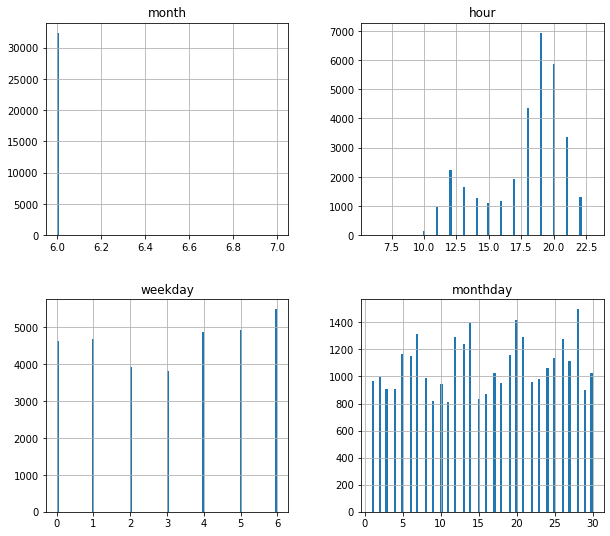

In [8]:
# Visualize and explore
df.hist(column = ['month', 'hour', 'weekday', 'monthday'], bins = 100, figsize=(10, 9));

In [9]:
df[df.month == 7]

,order_ready_at,order_value_gbp,restaurant_id,number_of_items,prep_time_seconds,country,city,type_of_food,month,hour,weekday,monthday
25474,2015-07-01 19:51:37.293042+01:00,107.5,811,8,20462,UK,London,italian,7,13,2,1


There is just one record from July, all the rest of records are from June, so the feature month can’t add much value to our prediction, so as the feauture year in this task. To handle this, I am going to ignore them in the rest of my anlysis.

In [10]:
df.drop('month', axis=1, inplace=True)

In [11]:
# Cyclical features encoding - hour, monthday, weekday
def encode(data, col, max_val):
    data[col + '_s'] = np.sin(2 * np.pi * data[col]/max_val)
    data[col + '_c'] = np.cos(2 * np.pi * data[col]/max_val)
    return data
df = encode(df, 'hour', 24)
df = encode(df, 'monthday', 30)
df = encode(df, 'weekday', 6)

## 4. Categorical features

There are few ways to handle the categorical features:
1. One-Hot encoding for categorical features. (Features would be too sparse in this task, because there are too many levels in restaurant_id).
2. Label encoding for categorical features. (It could be the input for the tree models).
3. cos/sin transfermation for cyclical features. (e.g. hours, weekday and monthday. But the tree models could handle the original data as well.)
4. Use group means/std to represent categorical data. (Need to be careful about data leaking).
5. Frequency encoding, it could tell us how popular a restaurant or type of food is. 
6. Deep Learning embedding.

In [12]:
# Label encoding categorical variables - country, city and type_of_food
countryid = df.country.astype('category').cat.codes
cityid = df.city.astype('category').cat.codes
type_of_food = df.type_of_food.astype('category').cat.codes
df['country_id'] = countryid.values
df['city_id'] = cityid.values
df['type_of_food_id'] = type_of_food.values

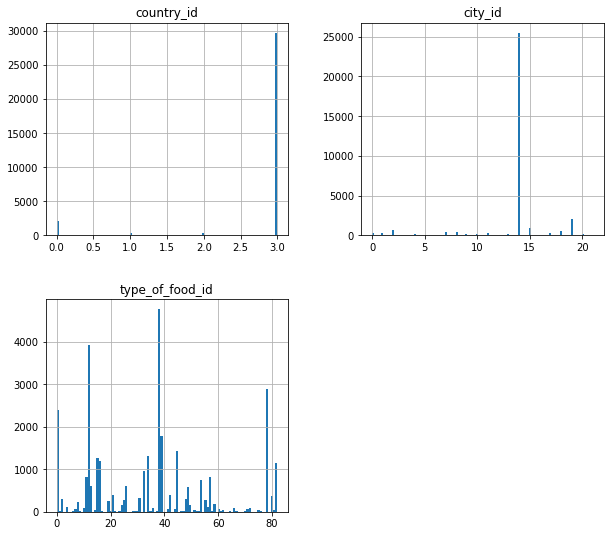

In [13]:
# Visualize and explore
df.hist(column = ['country_id', 'city_id', 'type_of_food_id'], bins = 100, figsize=(10, 9));

Country only has three values, and most of them are UK.

In [14]:
df.country.value_counts()

UK         29689
France      2032
Ireland      353
Germany      320
Name: country, dtype: int64

In [15]:
# In France, all the records are from Paris.
df[(df.country == 'France')&( df.city != 'Paris')]

,order_ready_at,order_value_gbp,restaurant_id,number_of_items,prep_time_seconds,country,city,type_of_food,hour,weekday,monthday,hour_s,hour_c,monthday_s,monthday_c,weekday_s,weekday_c,country_id,city_id,type_of_food_id


In [16]:
# In Ireland, all the records are from Dublin.
df[(df.country == 'Ireland')&( df.city != 'Dublin')]

,order_ready_at,order_value_gbp,restaurant_id,number_of_items,prep_time_seconds,country,city,type_of_food,hour,weekday,monthday,hour_s,hour_c,monthday_s,monthday_c,weekday_s,weekday_c,country_id,city_id,type_of_food_id


There are 4 countries in total. But in this table, France only has Pairs and Ireland only has Dublin. Germany has two, which are Munich and Berlin. So my guess is that country can’t add much value to my analysis, and the city feature will be enough to differentiate locations.

## 5. Check and Remove outliers

In [17]:
df.describe()

,order_value_gbp,restaurant_id,number_of_items,prep_time_seconds,hour,weekday,monthday,hour_s,hour_c,monthday_s,monthday_c,weekday_s,weekday_c,country_id,city_id,type_of_food_id
count,32394.000000,32394.000000,32394.000000,32394.000000,32394.000000,32394.000000,32394.000000,32394.000000,32394.000000,3.239400e+04,32394.000000,32394.000000,32394.000000,32394.000000,32394.000000,32394.000000
mean,26.547303,1290.555535,4.025715,1299.993857,17.728314,3.123511,15.870717,-0.727051,0.010161,-2.577470e-02,0.000358,-0.031840,0.207554,2.781163,13.659227,35.129468
std,19.263851,960.295504,2.392063,4404.573191,3.038744,2.064311,8.604748,0.347048,0.592340,7.095878e-01,0.704167,0.652793,0.727873,0.753052,3.213021,23.836933
min,0.500000,3.000000,1.000000,0.000000,6.000000,0.000000,1.000000,-1.000000,-1.000000,-9.945219e-01,-1.000000,-0.866025,-1.000000,0.000000,0.000000,0.000000
25%,16.700000,408.000000,3.000000,518.000000,16.000000,1.000000,8.000000,-0.965926,-0.500000,-7.431448e-01,-0.669131,-0.866025,-0.500000,3.000000,14.000000,13.000000
50%,21.400000,1160.000000,3.000000,820.000000,19.000000,3.000000,16.000000,-0.866025,0.258819,-1.133108e-15,0.104528,0.000000,0.500000,3.000000,14.000000,38.000000
75%,30.250000,2117.000000,5.000000,1227.000000,20.000000,5.000000,23.000000,-0.707107,0.500000,7.043049e-01,0.669131,0.866025,1.000000,3.000000,14.000000,48.000000
max,711.000000,3622.000000,38.000000,255499.000000,23.000000,6.000000,30.000000,1.000000,0.965926,9.945219e-01,1.000000,0.866025,1.000000,3.000000,21.000000,82.000000


The max value of number_of_items, order_value_gbp and prep_time_seconds are much larger than their 75% percentile. It is worth to check the outliers.  

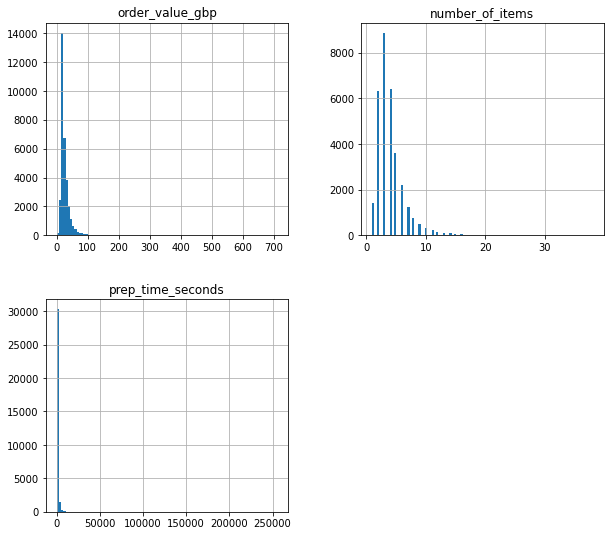

In [18]:
df.hist(column = ['order_value_gbp', 'number_of_items', 'prep_time_seconds'], bins = 100, figsize=(10, 9));

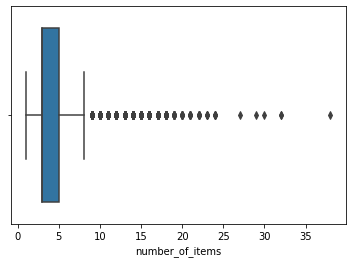

In [19]:
sns.boxplot(df['number_of_items']);

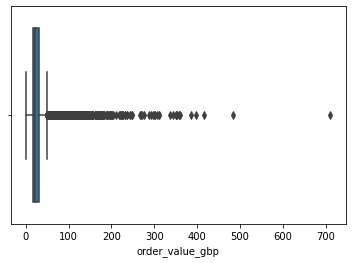

In [20]:
sns.boxplot(df['order_value_gbp']);

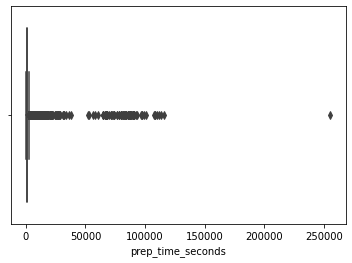

In [21]:
sns.boxplot(df['prep_time_seconds']);

##### Inter Quartile Range (IQR) approach to finding the outliers is the most commonly used and most trusted approach used in the research field.

In [22]:
# Detect IQR and remove outliers
def remove_outliers_iqr(df, column_name):
    Q1 = df[column_name].quantile(0.25)
    Q3 = df[column_name].quantile(0.75)
    IQR = Q3 - Q1
    print('{column_name} Q1: {Q1}'.format(column_name = column_name, Q1 = Q1))
    print('{column_name} Q3: {Q3}'.format(column_name = column_name, Q3 = Q3))
    print('{column_name} IQR: {IQR}'.format(column_name = column_name, IQR = IQR))
    # Dropping the Outliers
    df = df[~((df[column_name]< (Q1 - 1.5 * IQR)) | (df[column_name]> (Q3 + 1.5 * IQR)))]
    return df

In [23]:
df = remove_outliers_iqr(df, 'prep_time_seconds')

prep_time_seconds Q1: 518.0
prep_time_seconds Q3: 1227.0
prep_time_seconds IQR: 709.0


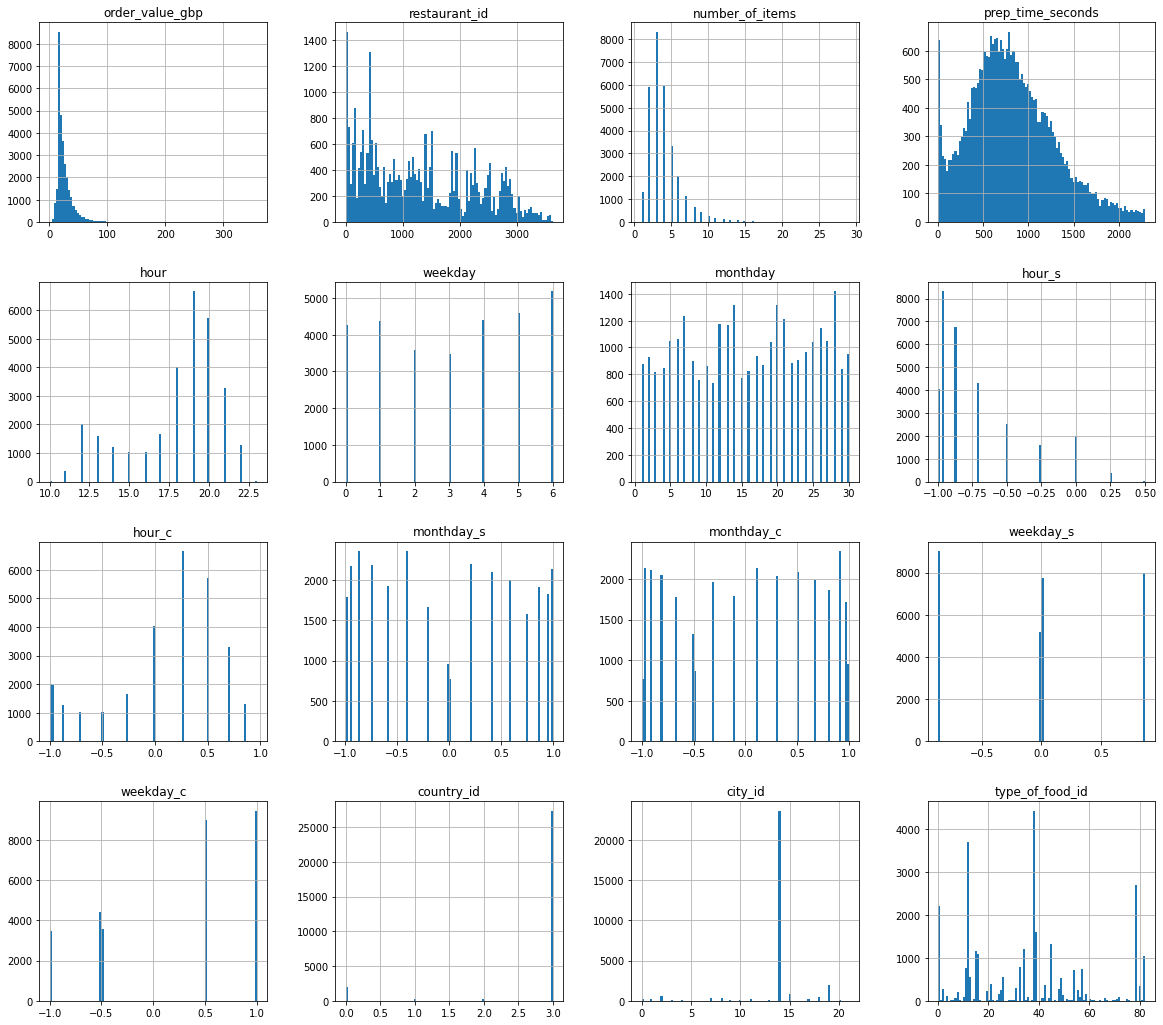

In [24]:
df.hist(bins = 100, figsize=(20, 18));

We can see from the figure above that there are still outliers in the order_value_gbp and number_of_items. 

In [25]:
# There are still some outliers in order_value_gbp
df = remove_outliers_iqr(df, 'order_value_gbp')

order_value_gbp Q1: 16.6
order_value_gbp Q3: 29.8
order_value_gbp IQR: 13.2


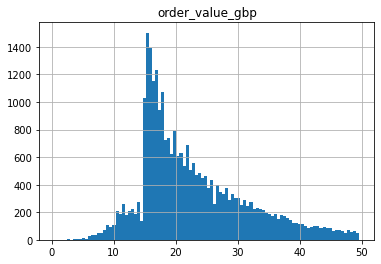

In [26]:
df.hist(column = ['order_value_gbp'], bins = 100);

To acheive a more accurate prediction, we could further trim the order_value_gbp and number_of_items, but as the cost the model would be less generalized. For example, if we further reduced the threshold used to trim the column number_of_items, the model would be more accurate on the orders with small number of items but less accurate on the on the orders with many items. 

## 6. Feature Observations

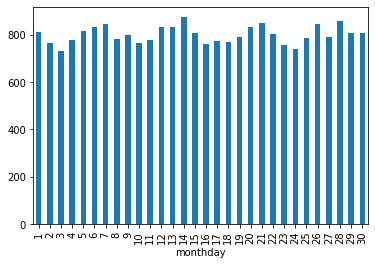

In [27]:
df.groupby([df.monthday]).prep_time_seconds.mean().plot(kind="bar");

We can see that, on different day of month, the prep time average are quite different. The figure also shows that there is a weekly patterns.

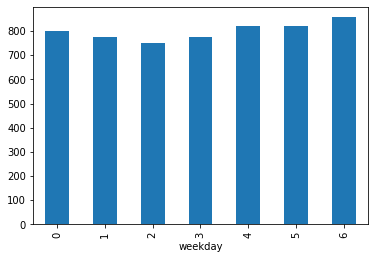

In [28]:
df.groupby([df.weekday]).prep_time_seconds.mean().plot(kind="bar");

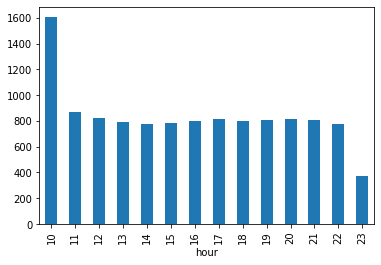

In [29]:
df.groupby([df.hour]).prep_time_seconds.mean().plot(kind="bar");

When we removed the outliers, the order happend in the morning and midnight have gone as well. Here we can see that there is a significant difference at different time, i.e. 10 am, 11 am - 22 pm and 23 pm. I tried to split it into 3 bins as follow, but it didn't improve the result. 
<!-- df.loc[df.hour > 22, 'hour'] = 0
df.loc[df.hour >= 11, 'hour'] = 1
df.loc[df.hour == 10, 'hour'] = 2 -->

In [30]:
# df.loc[df.hour > 22, 'hour'] = 0
# df.loc[df.hour >= 11, 'hour'] = 1
# df.loc[df.hour == 10, 'hour'] = 2

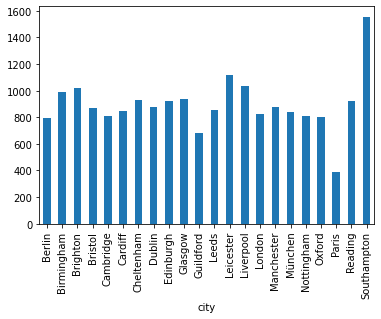

In [31]:
df.groupby([df.city]).prep_time_seconds.mean().plot(kind="bar");

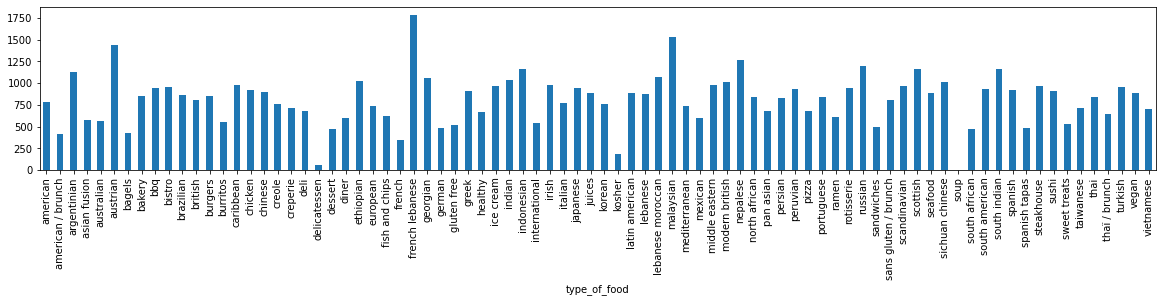

In [32]:
df.groupby([df.type_of_food]).prep_time_seconds.mean().plot(kind="bar", figsize=(20, 3));

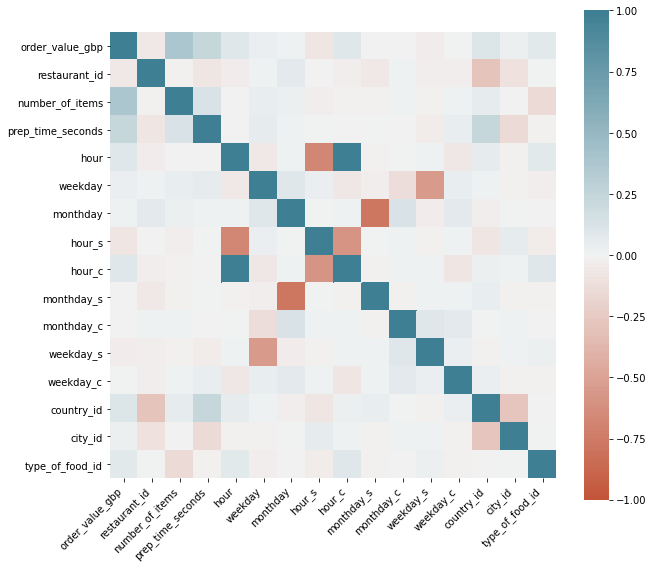

In [33]:
corr = df.corr()
plt.figure(figsize=(10,9))
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

In [34]:
df.restaurant_id.value_counts()

408     626
365     312
1939    267
1390    232
20      215
       ... 
234       1
1881      1
1705      1
1641      1
1983      1
Name: restaurant_id, Length: 1667, dtype: int64

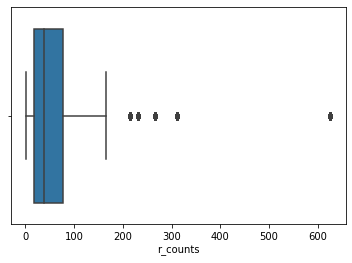

In [35]:
# Frequency encoding
df['r_counts'] = df['restaurant_id'].map(df.restaurant_id.value_counts()) 
sns.boxplot(df.r_counts);

In [36]:
counts1 = df['restaurant_id'].value_counts()
counts2 = df['type_of_food_id'].value_counts()
df = df[df['restaurant_id'].isin(counts1[counts1 > 20].index)]
df = df[df['type_of_food_id'].isin(counts2[counts2 > 20].index)]

## 8. Modelling 

In [37]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

# Evaluate model on test set.
def evaluate_model(y_test, y_predicted):
    sns.regplot(y_test, y_predicted, scatter_kws={"color": "black"}, line_kws={"color": "red"});
    r2 = r2_score(y_test, y_predicted)
    mse = mean_squared_error(y_test, y_predicted)
    print('Test R2: ', r2)
    print('Test MSE: ', mse)
    
# Define grid search
def grid_search(model, grid, X_train, y_train, cv):
    search = GridSearchCV(estimator = model, param_grid = grid, cv = cv, scoring = 'r2')
    grid_result = search.fit(X_train, y_train)
    # summarize results
    print("Best training R2: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
    best_model = grid_result.best_estimator_
    return best_model

### Feature sets 1

In [38]:
columns =  ['order_value_gbp',
            'number_of_items',
            'r_counts',
            'monthday',
            'hour',
            'weekday',
            'city_id',
            'country_id',
            'type_of_food_id', 
            'restaurant_id',
            'prep_time_seconds']
# Feature selection
df_selected = df[columns]

# Input and output variable
y = df_selected['prep_time_seconds']
X = df_selected.drop(columns=['prep_time_seconds'])

# Split train and test sets. 
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 12)

#### Random Forest Regressor 

Best training R2: 0.262636 using {'max_features': 'log2', 'min_samples_split': 4, 'n_estimators': 100}
Test R2:  0.28698922412096506
Test MSE:  142471.5799996359


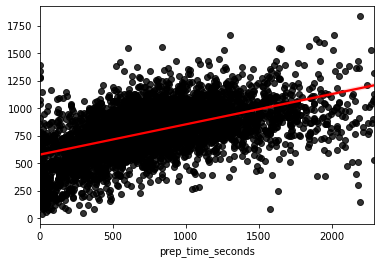

In [39]:
# Random Forest Regressor 
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor()

grid = {'n_estimators': [100],
        'max_features': ["auto", "sqrt", "log2"],
        "min_samples_split" : [2, 4, 6]}

# Search hyperparamters 
best_model = grid_search(model, grid, X_train, y_train, cv = 3)

# Evaluate model on the test set
y_predicted = best_model.predict(X_test)
evaluate_model(y_test, y_predicted)

### Feature sets 2

* Add a new feature which is the historical average preparation time of each restaurant.

In [40]:
# Append the restaurant average prep time
def transform_dataset(df, restaurant_mean):
    df = df.merge(restaurant_mean, how='left', on='restaurant_id', suffixes=('', '1'))
    df.dropna(inplace= True)
    columns =  ['monthday',
                'hour',
                'weekday',
                'city_id',
                'country_id',
                'type_of_food_id', 
                'restaurant_id',
                'r_counts',
                'order_value_gbp',
                'number_of_items',
                'prep_time_seconds1', # restaurant avg prep time       
                'prep_time_seconds']
    df = df[columns]
    y = df['prep_time_seconds']
    X = df.drop(columns=['prep_time_seconds'])
    return X, y

In [41]:
# Split train and test sets. Being careful with the test set leaking. 
df_train, df_test = train_test_split(df_selected, random_state = 12)

# Calculate the restaurant average prep time only using training data
restaurant_mean = df_train.groupby('restaurant_id').prep_time_seconds.mean()

# Append the restaurant average prep time to both train and test set
X_train, y_train = transform_dataset(df_train, restaurant_mean)
X_test, y_test = transform_dataset(df_test, restaurant_mean)

#### Random Forest Regressor

Best training R2: 0.336300 using {'max_features': 'log2', 'min_samples_split': 6, 'n_estimators': 100}
Test R2:  0.3369067074832188
Test MSE:  132497.22482182246


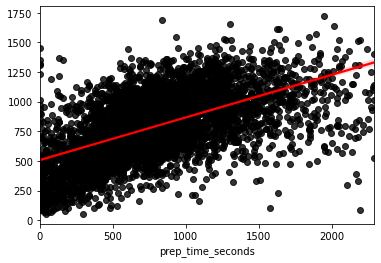

In [42]:
model = RandomForestRegressor()

grid = {'n_estimators': [100],
        'max_features': ["auto", "sqrt", "log2"],
        "min_samples_split" : [2, 4, 6]}

# Search hyperparamters 
best_model = grid_search(model, grid, X_train, y_train, cv = 3)

# Evaluate model on the test set
y_predicted = best_model.predict(X_test)
evaluate_model(y_test, y_predicted)

We can see that with this new feautre, both r2 and MSE performance haven been improved.

#### Gradient Boosting Regressor

Best training R2: 0.351832 using {'learning_rate': 0.1, 'min_samples_split': 4, 'n_estimators': 100}
Test R2:  0.34510140571216497
Test MSE:  130859.78588850646


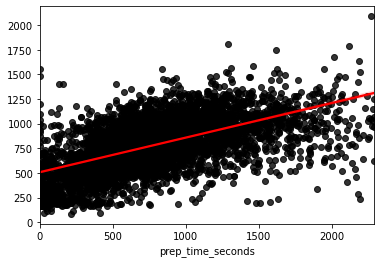

In [43]:
from sklearn.ensemble import GradientBoostingRegressor
model = GradientBoostingRegressor()

grid = {'n_estimators': [100],
        'min_samples_split': [2, 4, 6],
        'learning_rate': [0.03, 0.1, 0.3]}

# Search hyperparamters 
best_model = grid_search(model, grid, X_train, y_train, cv = 3)
# Evaluate model on the test set
y_predicted = best_model.predict(X_test)
evaluate_model(y_test, y_predicted)

#### Catboost Regressor

Best training R2: 0.360152 using {'depth': 6, 'iterations': 100, 'learning_rate': 0.1}
Test R2:  0.3533089965801026
Test MSE:  129219.7707884485


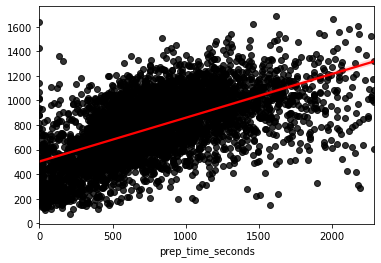

In [44]:
from catboost import CatBoostRegressor

model = CatBoostRegressor(silent = True)
grid = dict()
grid['depth'] = [6, 8, 10]
grid['learning_rate'] = [0.03, 0.1, 0.3]
grid['iterations'] = [100]
# Search hyperparamters 
best_model = grid_search(model, grid, X_train, y_train, cv = 3)

# Evaluate model on the test set
y_predicted = best_model.predict(X_test)
evaluate_model(y_test, y_predicted)

#### XGboost regressor

Best training R2: 0.351690 using {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 100}
Test R2:  0.34287189003254126
Test MSE:  131305.28072849446


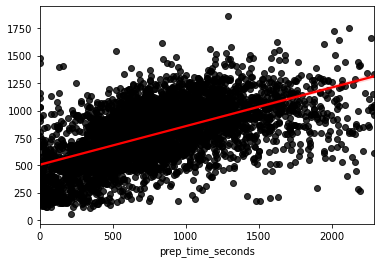

In [45]:
from xgboost import XGBRegressor
model = XGBRegressor()
grid = dict()
grid['max_depth'] = [4, 8, 12]
grid['learning_rate'] = [0.03, 0.1, 0.3]
grid['n_estimators'] = [100]
# Search hyperparamters 
best_model = grid_search(model, grid, X_train, y_train, cv = 3)

# Evaluate model on the test set
y_predicted = best_model.predict(X_test)
evaluate_model(y_test, y_predicted)

## 9. Model Comparison

In [46]:
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import Ridge
from numpy import mean
from numpy import std

# evaluate a give model using cross-validation
def evaluate_model_s(model, X_train, y_train):
    cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(model, X_train, y_train, scoring='r2', cv=3)
    return scores

# get a stacking ensemble of models
def get_stacking_models(gbr, rf, cat, xgb, final):
    # define the base models
    level0 = list()
    level0.append(('gbr', gbr))
    level0.append(('rf', rf))
    level0.append(('cat', cat))
    level0.append(('xgb', xgb))    
    # define meta learner model
    level1 = final
    # define the stacking ensemble
    model = StackingRegressor(estimators = level0, final_estimator = level1, cv = 3)
    return model

# get a list of models to evaluate
def get_models():
    rf = RandomForestRegressor(n_estimators =100, min_samples_split = 6, max_features = 'log2')
    gbr = GradientBoostingRegressor(n_estimators = 100, learning_rate = 0.1, min_samples_split = 2)
    cat = CatBoostRegressor(depth = 6, iterations = 100, learning_rate = 0.1, silent = True)
    xgb = XGBRegressor(max_depth = 4, n_estimators = 100, learning_rate = 0.1)
    stacking = get_stacking_models(gbr, rf, cat, xgb, Ridge(alpha = 0.3))
    models = dict()
    models['rf'] = rf
    models['gbr'] = gbr
    models['cat'] = cat
    models['xgb'] = xgb
    models['stacking'] = stacking
    return models

>rf 0.336 (0.010)
>gbr 0.352 (0.011)
>cat 0.360 (0.010)
>xgb 0.352 (0.011)
>stacking 0.360 (0.010)


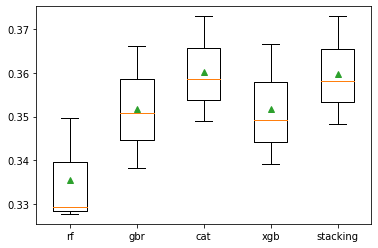

In [47]:
# get the models to evaluate
models = get_models()

# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model_s(model, X_train, y_train)
    results.append(scores)
    names.append(name)
    print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# plot model performance for comparison
plt.figure()
plt.boxplot(results, labels=names, showmeans=True)
plt.show()

## Concolution

* The dataset has some outliers, directly fitting model without removing them will result an inaccurate predication. In order to acheive a more accurate result, we could trim more on the data, but as the cost the model will be less generalized. For example, if we further reduced the threshold used to trim the column number_of_items, the model would be more accurate on the orders with small number of items but less accurate on the on the orders with many items. So there is a trade off, but busniess would probably benifit more by doing so, beacause the orders with small number of items appeared more frequently. So with this idea, we could eventually train a local model for each country or city rather than a global one.  

* Adding the feature - average preparation time - for each restaurant improves the performance. It is becuase that it introduce the historical information to the modelling stage. For the same reason, we could also calculate the avg prep time for each type of food and city. But a more proper evaluation should be conducted by spliting the training and testing set based on the timestamp, because we don't want the preparation time in the test set to be used in the averaging for the training set. \
Another advantage of these features is that, whenever there is a new restaurant from a new city which we don't have any data, we can still estimate its prep time based on the average prep time of its food type. 

In [48]:
### Lasso regression
# # Figure out which feature is categorical and which is numeric.
# df_selected[['city_id', 'type_of_food_id']] = df_selected[['city_id', 'type_of_food_id']].astype(object)

# # Column transformer
# cat_ix = X_train.select_dtypes(include=['object']).columns
# num_ix = X_train.select_dtypes(include=['int64', 'float64']).columns
# ct = ColumnTransformer([('c', OneHotEncoder(handle_unknown='ignore'), cat_ix), ('n', StandardScaler(), num_ix)])
# from sklearn.linear_model import Lasso
# # define the pipeline
# steps = [('transformer', ct), ('svd', TruncatedSVD()), ('regressor', Lasso())]
# model = Pipeline(steps=steps)
# grid = {
#         'svd__n_components' : [8, 12, 16],
#         'regressor__alpha': [-2, 1, 2]
# }
# # Search hyperparamters 
# best_model = grid_search(model, grid, X_train, y_train, cv = 3)
# # Evaluate model on the test set
# y_predicted = best_model.predict(X_test)
# evaluate_model(y_test, y_predicted)